In [1]:
cd /engelhardt/home/jboen/Experiments/GPzoo/

/engelhardt/home/jboen/Experiments/GPzoo


In [2]:
import numpy as np
import time

In [3]:
import torch
import matplotlib.pyplot as plt
from torch import optim, distributions, nn
from tqdm.autonotebook import tqdm
from gpzoo.kernels import RBF
from gpzoo.gp import VNNGP, SVGP, SVGP2
from gpzoo.likelihoods import GaussianLikelihood

/tmp/ipykernel_231274/2494729715.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [4]:
import gpytorch
from gpytorch.models import ApproximateGP
from gpytorch.variational.nearest_neighbor_variational_strategy import NNVariationalStrategy

In [12]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') #don't use Luis' GPU!
device

device(type='cuda', index=0)

In [13]:
N = 1000
X = distributions.Uniform(-5, 5).sample((N, ))
y = 2*torch.sin(2*X) + distributions.Normal(0.0, 0.1).sample((N,))

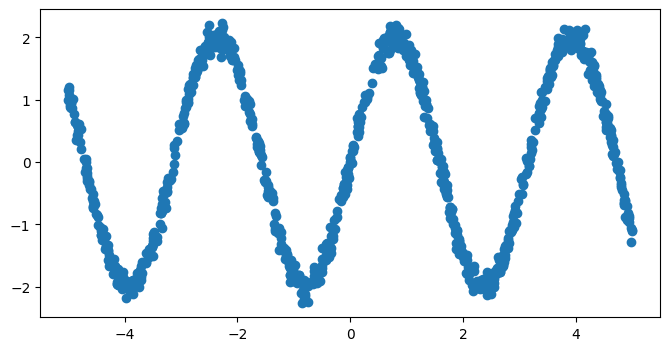

In [14]:
fig, ax = plt.subplots(figsize = (8,4))
ax.scatter(X, y)

In [15]:
X_train = (X[:, None]).to(device)
y_train = y.to(device)

In [16]:
class GPModel(ApproximateGP):
    def __init__(self, inducing_points, likelihood, k=256, training_batch_size=256):

        m, d = inducing_points.shape
        self.m = m
        self.k = k

        variational_distribution = gpytorch.variational.MeanFieldVariationalDistribution(m)

        if torch.cuda.is_available():
            inducing_points = inducing_points.cuda()

        variational_strategy = NNVariationalStrategy(self, inducing_points, variational_distribution, k=k,
                                                     training_batch_size=training_batch_size)
        super(GPModel, self).__init__(variational_strategy)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.MaternKernel(nu=2.5, ard_num_dims=d)

        self.likelihood = likelihood

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

    def __call__(self, x, prior=False, **kwargs):
        if x is not None:
            if x.dim() == 1:
                x = x.unsqueeze(-1)
        return self.variational_strategy(x=x, prior=False, **kwargs)

In [17]:
def fit_gpytorch(model, X, y, optimizer, num_epochs=1000, timing = False):
    
    # Our loss object. We're using the VariationalELBO
    mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=y.size(0))
    num_batches = model.variational_strategy._total_training_batches

    #storing data
    loss_values = np.zeros(num_epochs)

    if timing:
        timings = np.zeros(num_epochs)
        start_time = time.time()
    
    
    epochs_iter = tqdm(range(num_epochs), desc="Epoch")
    for epoch in epochs_iter:
        minibatch_iter = tqdm(range(num_batches), desc="Minibatch", leave=False)
    
        for i in minibatch_iter:
            optimizer.zero_grad()
            output = model(x=None)
            
            # Obtain the indices for mini-batch data
            current_training_indices = model.variational_strategy.current_training_indices
            
            # Obtain the y_batch using indices. It is important to keep the same order of train_x and train_y
            y_batch = y[current_training_indices].to(device)
            loss = -mll(output, y_batch)

            #storing data
            loss_values[epoch] = loss.item()

            if timing:
                timings[epoch] = time.time() - start_time
            
            minibatch_iter.set_postfix(loss=loss.item())
            loss.backward()
            optimizer.step()

    if timing:
        return loss_values, timings
    else:
        return loss_values

In [18]:
k = 10
training_batch_size = 64

likelihood = gpytorch.likelihoods.GaussianLikelihood()
gpytorch_model = GPModel(inducing_points=X_train, likelihood=likelihood, k=k, training_batch_size=training_batch_size)

gpytorch_model.to(device)

gpytorch_model.train()
likelihood.train()

optimizer = torch.optim.Adam(gpytorch_model.parameters(), lr=0.01)

gpytorch_losses, gpytorch_timings = fit_gpytorch(gpytorch_model, X_train, y_train, optimizer, num_epochs=1000, timing = True)

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

/engelhardt/home/jboen/.local/lib/python3.8/site-packages/gpytorch/distributions/multivariate_normal.py:319: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(


Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

In [19]:
# Get into evaluation (predictive posterior) mode
gpytorch_model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    X_test = torch.linspace(-6, 6, 150)
    observed_pred = likelihood(gpytorch_model(X_test.cuda()))

In [20]:
pF = gpytorch_model(X_test.cuda())

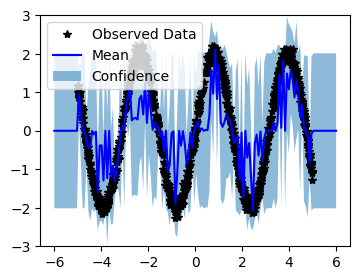

In [21]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(X, y, 'k*')
    # Plot predictive means as blue line
    ax.plot(X_test.cpu().numpy(), observed_pred.mean.cpu().numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(X_test.cpu().numpy(), lower.cpu().numpy(), upper.cpu().numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])

Text(0.5, 0, 'Time [s]')

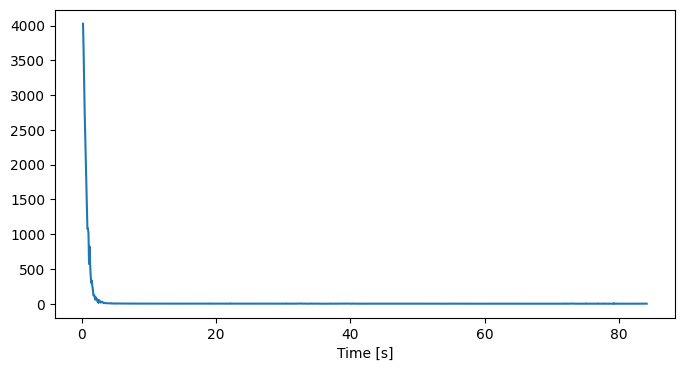

In [22]:
fig, ax = plt.subplots(figsize = (8,4))
ax.plot(gpytorch_timings, gpytorch_losses)
ax.set_xlabel("Time [s]")

In [23]:
def fit_gpzoo(model, X, y, optimizer, epochs=1000, E=20, timing = False):
    losses = np.zeros(epochs)

    timings = np.zeros(epochs)
    start_time = time.time()
    
    for it in tqdm(range(epochs)):
        optimizer.zero_grad()
        pY, qF, qU, pU = model.forward(X, E=E)
        ELBO = (pY.log_prob(y)).mean(axis=0).sum()
        ELBO -= torch.sum(distributions.kl_divergence(qU, pU))
        loss = -ELBO
        loss.backward()
        optimizer.step()
        
        losses[it] = loss.item()

        if timing:
            timings[it] = time.time() - start_time

    print("finished Training")

    if timing:
        return losses, timings
    else:
        return losses

In [25]:
kernel = RBF(sigma=1.0, lengthscale=3.0)

M = X_train.shape[0]

#use training set as inducing points
gp = VNNGP(kernel, dim=1, M=M, jitter=1e-1)
gp.Z = nn.Parameter(10.0*torch.rand((M, 1))-5.0)
#nn.Parameter(X_train)

#choose inducing points
#M = 100
#gp = VNNGP(kernel, dim=1, M=M, jitter=1e-3)
#gp.Z = nn.Parameter(10.0*torch.rand((M, 1))-5.0)

gpzoo_model = GaussianLikelihood(gp)
gpzoo_model.gp.K = 5

optimizer = torch.optim.Adam(gpzoo_model.parameters(), lr=0.01)

gpzoo_model.to(device)

gpzoo_losses, gpzoo_timings = fit_gpzoo(gpzoo_model, X_train, y_train, optimizer, epochs=1000, E=200, timing = True)

  0%|          | 0/1000 [00:00<?, ?it/s]

finished Training


Text(0.5, 0, 'Time [s]')

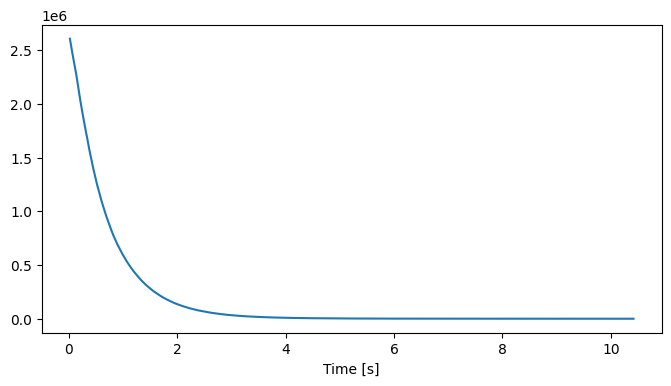

In [26]:
fig, ax = plt.subplots(figsize = (8,4))
ax.plot(gpzoo_timings, gpzoo_losses)
ax.set_xlabel("Time [s]")

In [27]:
X_test = torch.linspace(-6, 6, 150)

qF, _, _ = gpzoo_model.gp(X_test[:, None].to(device), verbose=True)
mean_test = qF.mean.detach().cpu()

calculating Kxx
Kxx.shape torch.Size([150, 1])
calculating Kxz
Kxz.shape torch.Size([150, 1000])
calculating kzz
Kzz.shape torch.Size([1, 1000, 1000])
calculating L
L.shape torch.Size([1, 1000, 1000])
Little_L.shape: torch.Size([1, 150, 5, 1000])
W_shape: torch.Size([150, 1, 5])
torch.Size([150, 1]) torch.Size([150, 5, 5]) torch.Size([150, 1, 5]) torch.Size([150, 5]) torch.Size([150, 5, 5])
mean.shape: torch.Size([150, 1, 1])
cov.shape: torch.Size([150, 1])


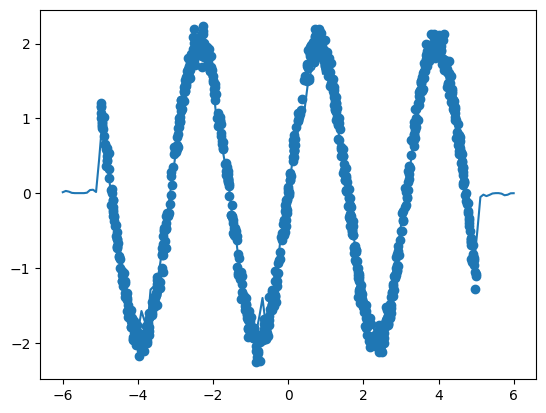

In [28]:
plt.plot(X_test, mean_test)
plt.scatter(X,y)

Text(0.5, 0, 'Time [s]')

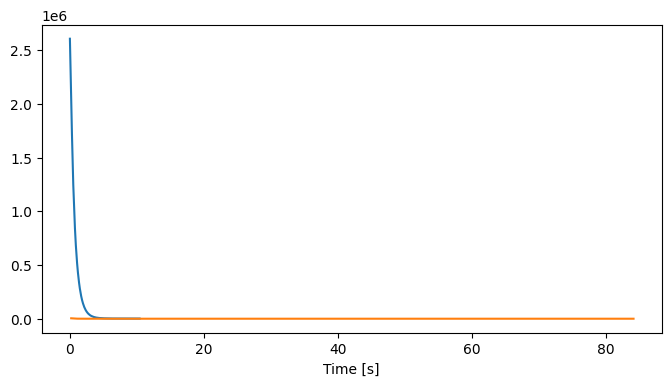

In [29]:
fig, ax = plt.subplots(figsize = (8,4))
ax.plot(gpzoo_timings, gpzoo_losses)
ax.plot(gpytorch_timings, gpytorch_losses)
ax.set_xlabel("Time [s]")
#ax.set_ylim((0,500))

In [30]:
gpytorch_timings.max(), gpzoo_timings.max()

(84.08918690681458, 10.417594909667969)

In [32]:
kernel = RBF(sigma=1.0, lengthscale=3.0)

M = X_train.shape[0]

gp = SVGP(kernel, dim=1, M=M, jitter=1e-1)
gp.Z = nn.Parameter(10.0*torch.rand((M, 1))-5.0)

gpzoo_model_svgp = GaussianLikelihood(gp)
gpzoo_model_svgp.to(device)

optimizer = torch.optim.Adam(gpzoo_model_svgp.parameters(), lr=0.01)

gpzoo_losses_svgp, gpzoo_timings_svgp = fit_gpzoo(gpzoo_model_svgp, X_train, y_train, optimizer, epochs=1000, E=200, timing = True)

  0%|          | 0/1000 [00:00<?, ?it/s]

_LinAlgError: linalg.cholesky: The factorization could not be completed because the input is not positive-definite (the leading minor of order 65 is not positive-definite).